# Fifth Exercise (Chapter 10)

This exercise focuses on recurrent neural networks (RNN). Also, we'll be using Pytorch from now on 🎉!

We will:
- implement an LSTM cell in Pytorch,
- train two forms of RNNs, namely:
    - many to one: value memorization
    - many to many: de-noising sequences

In [1]:
from typing import Tuple, Union

import numpy as np  # generate training data
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

## Preliminary Questions

Before we dive into the implementation parts, let's think about a few aspects of recurrent neural networks.
*Hint: Reading chapter 10 of the deep learning book might help with answering the questions.* Two other great resources are:
- Andrej Karpathy's [blog post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), which, among other things, nicely explains the different variants of RNNs (one-to-one, many-to-many, etc).
- Chris Olah's [blog post on LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).



**1.** In what sense are convolutional neural networks and recurrent neural networks similar? In what sense are they different?

**Answer**:  
They are similar in the sense that they both use shared weights in the network.
They are different because CNNs operate on a fixed-size input and produce a fixed-size output. In contrast to that, RNNs operate on arbitrary-length sequences, output arbitrary-length sequences and preserve the context in the memory over time.

**2.** How can one counteract vanishing or exploding gradients in RNNs, allowing to learn long-term dependencies?

**Answer**:  
- Exploding gradients:
    - use shrinkage methods for recurrent weight
    - use gradient clipping when the norm exceeds a certain threshold
- Vanishing gradients:
    - use orthogonal initialization of weights
    - use specially designed architectures that solve this problem (e.g. LSTM)


## LSTM cell
See chapter 10.10.1 of the DL book.

In Pytorch, all layers inherit from `nn.Module` and implement the `forward` function (the `backward` pass is computed automatically). Parameters should be initialized in the constructor.

To get a feeling for how layers are implemented in pytorch, you can for example take a look at the source code of the [Linear layer](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear) ($h = wX+b$).

Your task here is to implement the LSTMCell, which takes a feature tensor and the hidden state as input and returns the new hidden state (sometimes also referred to as output) and the new cell state.


In [122]:
from torch.nn.parameter import Parameter
from torch import Tensor

class LSTMCell(nn.Module):
    """The LSTM layer."""
    
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # START TODO #############
        # initialize required parameters / layers
        stdv = 1. / np.sqrt(self.hidden_size)
        # Forget
        self.W_forget = Parameter(Tensor(self.hidden_size, self.hidden_size + self.input_size).uniform_(-stdv, stdv))
        self.b_forget = Parameter(Tensor(self.hidden_size))
        # Input
        self.W_input = Parameter(Tensor(self.hidden_size, self.hidden_size + self.input_size).uniform_(-stdv, stdv))
        self.b_input = Parameter(Tensor(self.hidden_size))
        # Candidate
        self.W_candidate = Parameter(Tensor(self.hidden_size, self.hidden_size + self.input_size).uniform_(-stdv, stdv))
        self.b_candidate = Parameter(Tensor(self.hidden_size))
        # Output
        self.W_output = Parameter(Tensor(self.hidden_size, self.hidden_size + self.input_size).uniform_(-stdv, stdv))
        self.b_output = Parameter(Tensor(self.hidden_size))
        # END TODO #############
        
    def forward(self, x: torch.Tensor, hx: Tuple[torch.Tensor] = None) -> Tuple[torch.Tensor]:
        """
        
        Args:
            x: The input tensor with shape (batch_size, feature_dim)
            hx: The initial hidden state, optional. Is a two-tuple consisting of
                the current hidden state and the internal cell state. Both have
                shape (batch_size, hidden_size).
                
        Returns:
            Tuple as (output_hidden, new_internal_state).
        """
        if hx is None:
            hx = self._init_hidden_state(x)
        # START TODO #############
        h, C = hx
        print("x:", x.shape)
        print("h:", h.shape)
        print("C:", C.shape)
        h_x_concat = torch.cat([h, x], dim=1)
        # Forget
        forget = torch.sigmoid(
            torch.matmul(self.W_forget, h_x_concat) + self.b_forget
        )
        # Input
        input = torch.sigmoid(
            torch.matmul(self.W_input, h_x_concat) + self.b_input
        )
        
        # Candidate
        C_tilde = torch.tanh(
            torch.matmul(self.W_candidate, h_x_concat) + self.b_candidate
        )
        
        # New internal cell state (C)
        C = forget * C + input * C_tilde
        # New hidden state
        o = torch.sigmoid(
            torch.matmul(self.W_output, h_x_concat) + self.b_output
        )
        h = o * torch.tanh(C)
        return h, C
        # END TODO #############
        
    def _init_hidden_state(self, x):
        """Returns the hidden state with zeros.
        
        Returns:
            A two-tuple (initial_hidden_state, initial_cell_state).
            Both are all zeros with shape (batch_size, hidden_size).
        """
        # START TODO #############
        batch_size = x.shape[0]
        return (
            torch.zeros(batch_size, self.hidden_size),
            torch.zeros(batch_size, self.hidden_size)
        )
        # END TODO #############

In [123]:
class LSTM(LSTMCell):
    """Convenience class that automatically iterates over the sequence."""
    
    def forward(self, x: Union[np.ndarray, torch.Tensor], hx=None):
        """Iterate over the sequence and apply the LSTM cell.
        
        Args:
            x: The input tensor with shape (seq_len, batch, input_size)
            hx: The initial hidden state, optional. Is a two-tuple consisting of
                the current hidden state and the internal cell state. Both have
                shape (batch_size, hidden_size). If None, set to zero.
        
        Returns:
            Tuple as (output_stacked_hidden, (last_hidden_state, last_new_internal_state)).
            output_stacked_hidden is the stacked output of all LSTMCells
            (excluding the cell state!)
        """
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x, requires_grad=True)
        # START TODO #############
        outputs = []
        # iterate over the sequence and apply the LSTM
        seq_len, batch_size, input_size = x.shape
        for idx in range(seq_len):
            element = x[idx, :, :, None]
            hx = LSTMCell.forward(self, element, hx)
            last_internal_state = hx[1]
            last_hidden_state = hx[0]
            outputs.append(last_hidden_state)

        output_stacked_hidden = torch.stack(outputs, 0)
        return output_stacked_hidden, (last_hidden_state, last_internal_state)
        # END TODO #############

As a simple test, let's see if the LSTM can learn to echo a value at a specific index of the sequence. If your implementation is correct, you should get around 97% accuracy.

In [124]:
# Create 100 training sequences of length 10
num_samples = 1000
seq_length = 10
batch_size = 5
# we use a hidden size larger 1 as it makes training easier
# as prediction we compute the mean over the output.
hidden_size = 6
training_sequences = torch.rand(seq_length, num_samples, 1)
test_sequences = torch.rand(seq_length, 100, 1)
model = LSTM(1, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')


def accuracy(y, label, eps=1e-2):
    assert y.shape == label.shape, (y.shape, label.shape)
    return np.sum(np.abs(y - label) < eps) / len(y)


for epoch in range(101):
    for batch_idx in range(num_samples // batch_size):
        optimizer.zero_grad()
        batch = training_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
        output = model(batch)[1][0]
        #output = output[:, :, 0]
        labels = batch[1]  # echo the second element
        loss = loss_fn(labels, output)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        print(f"epoch: {epoch}, loss:{loss}")
        output = model(test_sequences)[1][0]
        #output = output[:, :, 0]
        labels = test_sequences[1]  # echo the second element
        acc = accuracy(np.squeeze(labels.numpy()),
                       np.mean(output.detach().numpy(), axis=-1))
        print(f"test accuracy: {acc}")
    scheduler.step()
    

x: torch.Size([5, 1, 1])
h: torch.Size([5, 6])
C: torch.Size([5, 6])


RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 2 and 3 at /opt/conda/conda-bld/pytorch_1533672544752/work/aten/src/TH/generic/THTensorMath.cpp:3607

## LSTM Use Case - Noise Removal
Implement an RNN to remove noise from different sine function instances. If you didn't finish the `LSTM` implementation part, you can use `nn.LSTM` here.

The goal is to remove gaussian noise from a sequence generated from a sine function.

To get an idea what the data look like, plot six different sine function instances with and without noise.

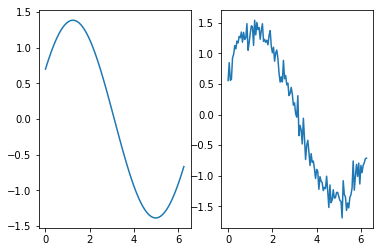

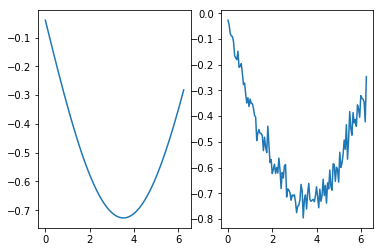

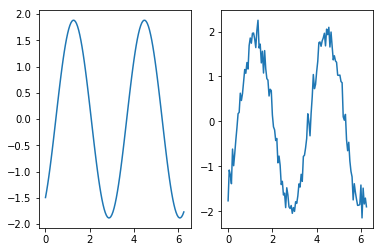

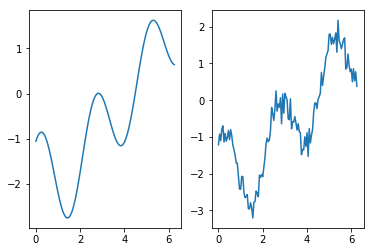

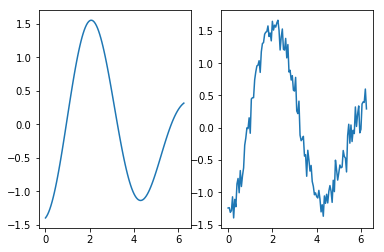

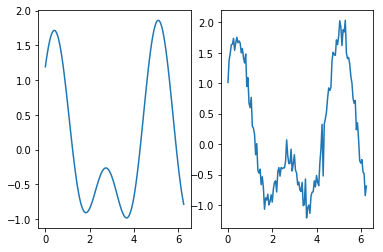

In [28]:
# let's create a generator for sine functions with different amplitudes, shift and frequency

class RandomSineFunction:
    
    def __init__(self):
        num_sines = np.random.randint(1, 4)
        self.amplitude = np.random.uniform(0, 2, num_sines)
        self.offsets = np.random.uniform(-np.pi, np.pi, num_sines)
        self.frequency = np.random.uniform(0.1, 1, num_sines)
        
    def __call__(self, x):
        return np.array([a * np.sin(np.pi * f * x + o)
                         for a, f, o in zip(self.amplitude, self. frequency, self.offsets)]).sum(axis=0)

    
def sample_sine_functions(num_functions):
    return [RandomSineFunction() for _ in range(num_functions)]


def noisy(y, noise_ratio=0.05, axes=None):
    noise_range = np.ptp(y, axis=axes, keepdims=True) * noise_ratio
    return y + np.random.normal(0, noise_range, size=y.shape)

# START TODO #############
fs = sample_sine_functions(6)
xs = np.arange(0, 2 * np.pi, 0.05)
for f in fs:
    ys = f(xs)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(xs, ys)
    plt.subplot(1, 2, 2)
    plt.plot(xs, noisy(ys))
# END TODO #############


Now it's time to define the model! Let's stack two LSTMs both with output shape (sequence_length, batch_size, hidden_size) followed by a Linear layer which takes a (sequence_length, batch_size, hidden_size) vector as input and outputs a tensor with shape (sequence_length, batch_size, 1).


To allow the model to see some values before estimating the output, pad the sequence accordingly.

In [125]:
class NoiseRemovalModel(nn.Module):
    """
    """
    
    def __init__(self, hidden_size: int, shift: int = 10):
        """
        Args:
            hidden_size: the number of units of the LSTM hidden state size.
            shift:       the number of steps the RNN is run before its output
                             is considered ("many-to-many shifted to the right").
        """
        super().__init__()
        self.shift = shift
        # START TODO #############
        self.lstm1 = nn.LSTM(1, hidden_size)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size)
        self.linear = torch.nn.Linear(hidden_size, 1)
        # END TODO #############
        
        
    def forward(self, x: np.ndarray) -> torch.Tensor:
        """Forward pass of noise removal.
        
        This function
        1) pads the input sequence with self.interval zeros at the end,
        2) applies an LSTM
        3) cuts the first self.interval outputs
        4) applies another LSTM
        5) applies Linear layer.
        
        Args:
            x: The input sequence
        
        Returns:
            A torch.Tensor of shape (sequence length, batch_size, 1)
        """
        # Pad input sequence x at the end (shifted many-to-many model).
        # This allows the model to see a few numbers before it has to guess
        # the noiseless output.
        
        # START TODO #############
        # LSTM
        padding = torch.zeros(self.shift, *x.shape[1:])
        x_padded = torch.cat([x, padding], dim=0)
        output_stacked_hidden, hx = self.lstm1(x_padded)
        
        # LSTM
        #x_cut = output_stacked_hidden[self.shift:, :, :, 0]
        x_cut = output_stacked_hidden[self.shift:, :, :]
        output_stacked_hidden, hx = self.lstm2(x_cut, hx) # remove the 1 at the end
        
        # Linear
        out = self.linear(output_stacked_hidden) # remove the 1 at the end
        return out
        # END TODO #############

In [126]:
num_functions = 200
sequence_length = 80
noise_ratio = 0.05
np.random.seed(0)
train_functions = sample_sine_functions(num_functions)
val_functions = sample_sine_functions(50)
# interval on which we'll train and evaluate
x = np.linspace(0, 5, sequence_length)


def prepare_sequences(functions):
    """Convert to tensor and create noisy sequence"""
    sequences = np.array([f(x).reshape(-1, 1) for f in functions])
    # put the sequence into the first dimension
    sequences = sequences.transpose([1, 0, 2])
    # add some noise
    noisy_sequences = noisy(sequences, noise_ratio, axes=(0, 2))
    return torch.Tensor(sequences), torch.Tensor(noisy_sequences)


train_sequences, noisy_train_sequences = prepare_sequences(train_functions)
val_sequences, noisy_val_sequences = prepare_sequences(val_functions)

In [127]:
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')


def plot_curves(ground_truth, noisy_sequence, model_output):
    plt.figure(figsize=(14,3))
    for i in range(min(len(ground_truth), 5)):
        plt.subplot(1, 5, i + 1)
        plt.plot(x, ground_truth[i], label="ground_truth")
        plt.plot(x, noisy_sequence[i], label="noisy_sequence")
        plt.plot(x, model_output[i], label="model_output")
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()

    
def percentage_noise_removed(ground_truth, noisy_sequence, model_output):
    """Computes the percentage of noise the model removed."""
    return 100 * (1 - (np.abs(ground_truth - model_output).sum() /
                  np.abs(ground_truth - noisy_sequence).sum()))


def train(model, optimizer, scheduler, num_epochs, batch_size, plot=True):
    num_samples = train_sequences.shape[0]
    for epoch in range(num_epochs):
        # START TODO #############
        for batch_idx in range(num_samples // batch_size):
            optimizer.zero_grad()
            batch = noisy_train_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
            output = model(batch)
            labels = train_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
            loss = loss_fn(labels, output)
            loss.backward()
            optimizer.step()
        # END TODO #############
        print(f"epoch: {epoch}, train loss:{loss}")
        # compute the validation loss
        output = model(noisy_val_sequences)
        loss = loss_fn(val_sequences, output)
        print(f"epoch: {epoch}, validation loss:{loss}")
        if epoch % 10 == 0:
            np_tensors = [a.detach().numpy().transpose([1, 0, 2])
                          for a in (val_sequences, noisy_val_sequences, output)]
            if plot:
                plot_curves(*np_tensors)
            print(f"{percentage_noise_removed(*np_tensors):2.4f}% of noise removed.")
        scheduler.step()


epoch: 0, train loss:388.50799560546875
epoch: 0, validation loss:1669.261962890625


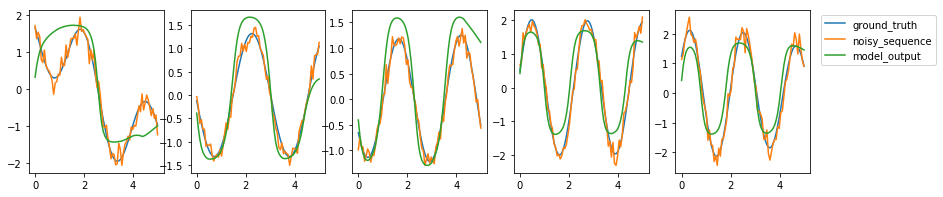

-334.4222% of noise removed.
epoch: 1, train loss:345.1047058105469
epoch: 1, validation loss:1426.809326171875
epoch: 2, train loss:252.29437255859375
epoch: 2, validation loss:1187.8994140625
epoch: 3, train loss:179.956298828125
epoch: 3, validation loss:1006.3783569335938
epoch: 4, train loss:138.4174041748047
epoch: 4, validation loss:668.2930908203125
epoch: 5, train loss:94.08795928955078
epoch: 5, validation loss:433.85638427734375
epoch: 6, train loss:73.65431213378906
epoch: 6, validation loss:331.72552490234375
epoch: 7, train loss:65.5114517211914
epoch: 7, validation loss:327.7192077636719
epoch: 8, train loss:46.52985382080078
epoch: 8, validation loss:262.7562255859375
epoch: 9, train loss:39.453216552734375
epoch: 9, validation loss:176.8531951904297
epoch: 10, train loss:39.569053649902344
epoch: 10, validation loss:169.8726806640625


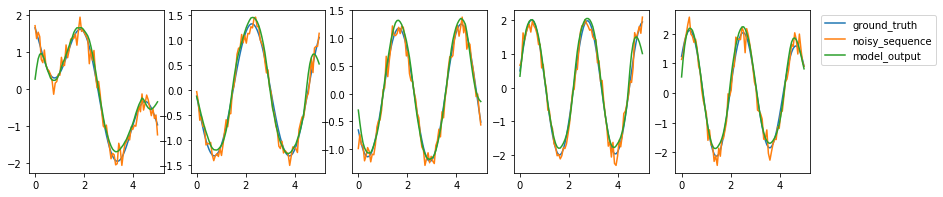

-3.8261% of noise removed.
epoch: 11, train loss:40.74995040893555
epoch: 11, validation loss:252.769287109375
epoch: 12, train loss:51.638858795166016
epoch: 12, validation loss:172.49594116210938
epoch: 13, train loss:47.495750427246094
epoch: 13, validation loss:157.68263244628906
epoch: 14, train loss:39.40092849731445
epoch: 14, validation loss:148.71694946289062
epoch: 15, train loss:33.85435104370117
epoch: 15, validation loss:136.8336944580078
epoch: 16, train loss:24.723804473876953
epoch: 16, validation loss:121.47555541992188
epoch: 17, train loss:22.578876495361328
epoch: 17, validation loss:118.26099395751953
epoch: 18, train loss:23.213747024536133
epoch: 18, validation loss:98.95651245117188
epoch: 19, train loss:22.010791778564453
epoch: 19, validation loss:101.67264556884766
epoch: 20, train loss:18.49172019958496
epoch: 20, validation loss:95.18022155761719


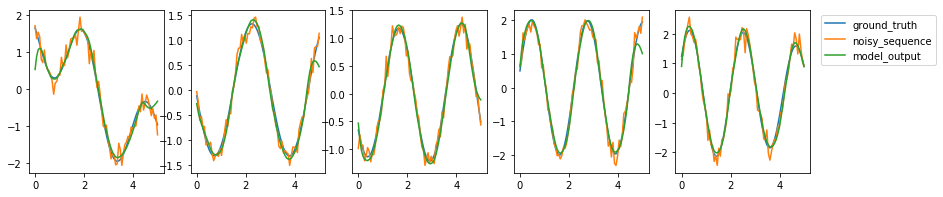

28.4275% of noise removed.
epoch: 21, train loss:17.76767349243164
epoch: 21, validation loss:99.29132080078125
epoch: 22, train loss:19.391794204711914
epoch: 22, validation loss:105.77523040771484
epoch: 23, train loss:18.3907527923584
epoch: 23, validation loss:100.9414291381836
epoch: 24, train loss:18.24600601196289
epoch: 24, validation loss:96.24349975585938
epoch: 25, train loss:19.408601760864258
epoch: 25, validation loss:94.295654296875
epoch: 26, train loss:17.566686630249023
epoch: 26, validation loss:90.40412902832031
epoch: 27, train loss:14.918989181518555
epoch: 27, validation loss:89.6893310546875
epoch: 28, train loss:16.404190063476562
epoch: 28, validation loss:100.07638549804688
epoch: 29, train loss:19.78927230834961
epoch: 29, validation loss:97.47293853759766
epoch: 30, train loss:15.904797554016113
epoch: 30, validation loss:91.63607788085938


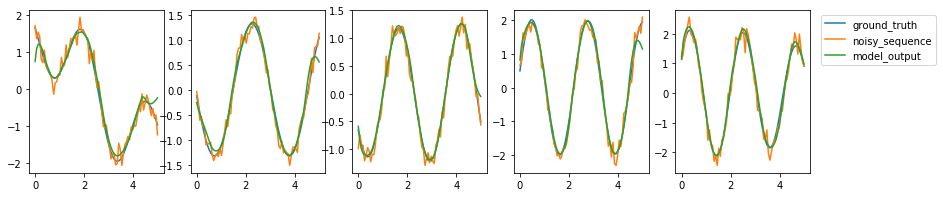

19.5810% of noise removed.
epoch: 31, train loss:20.738685607910156
epoch: 31, validation loss:118.72227478027344
epoch: 32, train loss:15.982601165771484
epoch: 32, validation loss:126.17557525634766
epoch: 33, train loss:20.242616653442383
epoch: 33, validation loss:95.7001724243164
epoch: 34, train loss:19.373891830444336
epoch: 34, validation loss:98.61882781982422
epoch: 35, train loss:15.910816192626953
epoch: 35, validation loss:93.57474517822266
epoch: 36, train loss:20.676593780517578
epoch: 36, validation loss:93.33900451660156
epoch: 37, train loss:15.886878967285156
epoch: 37, validation loss:94.01239776611328
epoch: 38, train loss:19.771045684814453
epoch: 38, validation loss:102.85847473144531
epoch: 39, train loss:17.471294403076172
epoch: 39, validation loss:110.95064544677734
epoch: 40, train loss:16.152809143066406
epoch: 40, validation loss:120.25889587402344


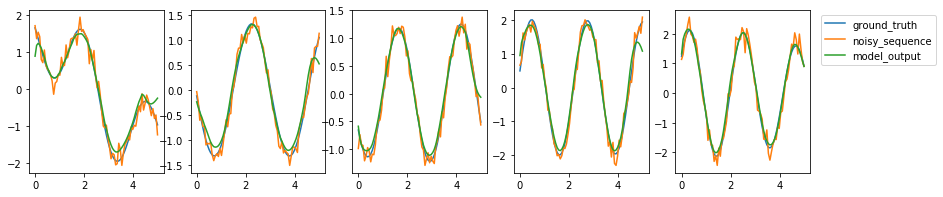

2.0645% of noise removed.
epoch: 41, train loss:16.351564407348633
epoch: 41, validation loss:116.64570617675781
epoch: 42, train loss:11.43048095703125
epoch: 42, validation loss:105.04802703857422
epoch: 43, train loss:10.56691837310791
epoch: 43, validation loss:83.34162139892578
epoch: 44, train loss:10.38526439666748
epoch: 44, validation loss:69.38506317138672
epoch: 45, train loss:12.369759559631348
epoch: 45, validation loss:71.98124694824219
epoch: 46, train loss:13.327025413513184
epoch: 46, validation loss:80.57760620117188
epoch: 47, train loss:10.998810768127441
epoch: 47, validation loss:77.13285064697266
epoch: 48, train loss:9.210403442382812
epoch: 48, validation loss:65.81623840332031
epoch: 49, train loss:8.869330406188965
epoch: 49, validation loss:63.99090576171875
epoch: 50, train loss:8.71603775024414
epoch: 50, validation loss:64.67676544189453


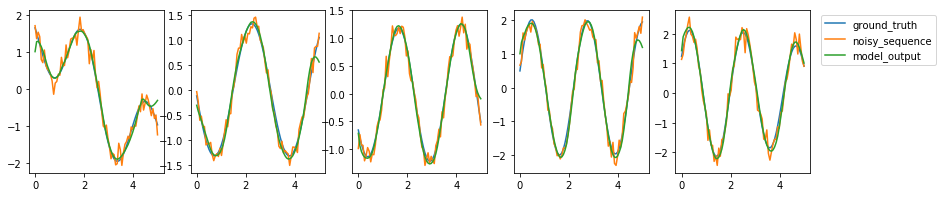

38.3939% of noise removed.
epoch: 51, train loss:8.681504249572754
epoch: 51, validation loss:63.49637222290039
epoch: 52, train loss:8.84632396697998
epoch: 52, validation loss:64.2951431274414
epoch: 53, train loss:8.606383323669434
epoch: 53, validation loss:63.83037567138672
epoch: 54, train loss:8.127082824707031
epoch: 54, validation loss:61.79751205444336
epoch: 55, train loss:7.86858606338501
epoch: 55, validation loss:60.78131866455078
epoch: 56, train loss:7.846175193786621
epoch: 56, validation loss:60.3769645690918
epoch: 57, train loss:7.836792945861816
epoch: 57, validation loss:60.34389877319336
epoch: 58, train loss:7.666867256164551
epoch: 58, validation loss:59.97056198120117
epoch: 59, train loss:7.45443058013916
epoch: 59, validation loss:59.03396987915039
epoch: 60, train loss:7.331937313079834
epoch: 60, validation loss:58.47990417480469


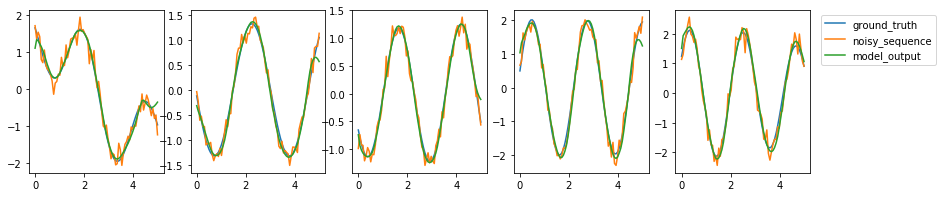

40.6755% of noise removed.
epoch: 61, train loss:7.245490074157715
epoch: 61, validation loss:58.14541244506836
epoch: 62, train loss:7.123045444488525
epoch: 62, validation loss:57.55201721191406
epoch: 63, train loss:7.049281120300293
epoch: 63, validation loss:57.27006912231445
epoch: 64, train loss:6.975566387176514
epoch: 64, validation loss:57.02613830566406
epoch: 65, train loss:6.85484504699707
epoch: 65, validation loss:56.31074905395508
epoch: 66, train loss:6.801231861114502
epoch: 66, validation loss:55.81368637084961
epoch: 67, train loss:6.823964595794678
epoch: 67, validation loss:55.791046142578125
epoch: 68, train loss:6.838763236999512
epoch: 68, validation loss:55.2066650390625
epoch: 69, train loss:6.913326740264893
epoch: 69, validation loss:54.48292922973633
epoch: 70, train loss:7.08897590637207
epoch: 70, validation loss:54.30438232421875


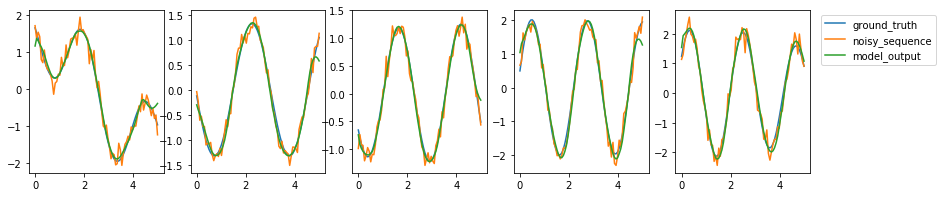

41.7704% of noise removed.
epoch: 71, train loss:7.24678373336792
epoch: 71, validation loss:54.03158950805664
epoch: 72, train loss:7.229084491729736
epoch: 72, validation loss:53.754783630371094
epoch: 73, train loss:6.992595195770264
epoch: 73, validation loss:53.512630462646484
epoch: 74, train loss:6.657999515533447
epoch: 74, validation loss:52.89511489868164
epoch: 75, train loss:6.446228504180908
epoch: 75, validation loss:52.386138916015625
epoch: 76, train loss:6.433335781097412
epoch: 76, validation loss:52.132362365722656
epoch: 77, train loss:6.517955303192139
epoch: 77, validation loss:51.98511505126953
epoch: 78, train loss:6.48313570022583
epoch: 78, validation loss:51.84587478637695
epoch: 79, train loss:6.344573020935059
epoch: 79, validation loss:51.55647659301758
epoch: 80, train loss:6.307703495025635
epoch: 80, validation loss:51.30607986450195


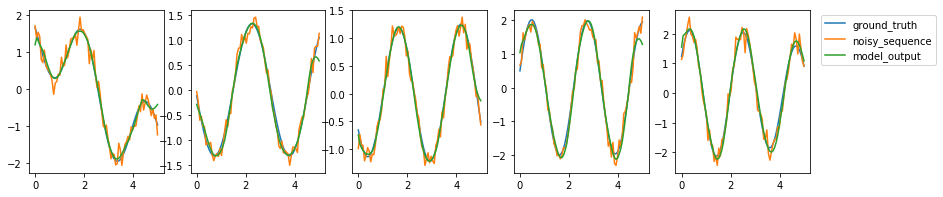

43.3090% of noise removed.
epoch: 81, train loss:6.325417518615723
epoch: 81, validation loss:51.17287063598633
epoch: 82, train loss:6.26894474029541
epoch: 82, validation loss:51.01555633544922
epoch: 83, train loss:6.243649005889893
epoch: 83, validation loss:50.857421875
epoch: 84, train loss:6.230345249176025
epoch: 84, validation loss:50.72017288208008
epoch: 85, train loss:6.196995258331299
epoch: 85, validation loss:50.59468078613281
epoch: 86, train loss:6.186498641967773
epoch: 86, validation loss:50.49673843383789
epoch: 87, train loss:6.1646504402160645
epoch: 87, validation loss:50.3974723815918
epoch: 88, train loss:6.153408050537109
epoch: 88, validation loss:50.31635665893555
epoch: 89, train loss:6.138146877288818
epoch: 89, validation loss:50.24259948730469
epoch: 90, train loss:6.127865791320801
epoch: 90, validation loss:50.18128204345703


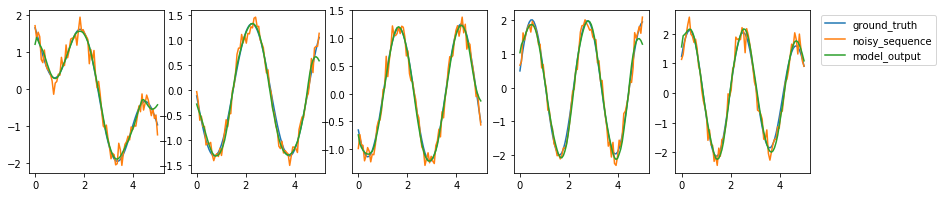

43.8100% of noise removed.
epoch: 91, train loss:6.1179327964782715
epoch: 91, validation loss:50.128273010253906
epoch: 92, train loss:6.109037399291992
epoch: 92, validation loss:50.084075927734375
epoch: 93, train loss:6.102110385894775
epoch: 93, validation loss:50.04813003540039
epoch: 94, train loss:6.096129417419434
epoch: 94, validation loss:50.01912307739258
epoch: 95, train loss:6.091108322143555
epoch: 95, validation loss:49.99654769897461
epoch: 96, train loss:6.0871477127075195
epoch: 96, validation loss:49.97978591918945
epoch: 97, train loss:6.084115982055664
epoch: 97, validation loss:49.967979431152344
epoch: 98, train loss:6.081857204437256
epoch: 98, validation loss:49.96030044555664
epoch: 99, train loss:6.080273151397705
epoch: 99, validation loss:49.95589065551758
epoch: 100, train loss:6.079267501831055
epoch: 100, validation loss:49.953895568847656


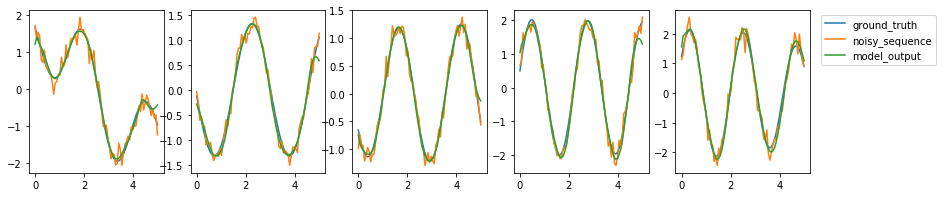

43.9101% of noise removed.


In [128]:
batch_size = 10
num_epochs = 101


model = NoiseRemovalModel(hidden_size=40, shift=10)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# this should remove ~32% of the noise
train(model, optimizer, scheduler, num_epochs, batch_size)

## Hyperparameter Optimization
As a preparation for next week's lecture, play with the model's hyperparameters and try to improve the amount of noise removed. List at least three different configurations you have tried and the respective percentage of noise removed. Make sure to always create a new model and that you train and validate on the same data!

| configuration        | Noise removed in percent |
| -------------------- | --------------------------: |
| initial configuration| 32.52%               |

In [ ]:
# don't forget to create a new model each time!
# START TODO #############
